In [37]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

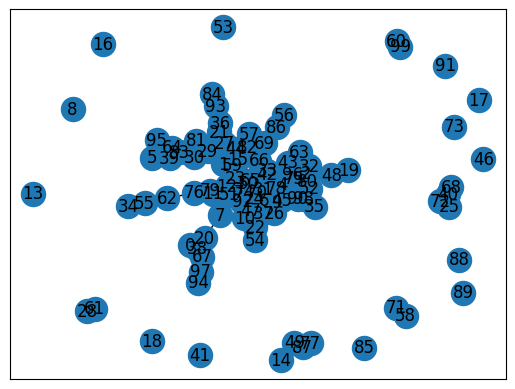

In [2]:
G = nx.gnp_random_graph(100, 0.02, seed=42) # Graph size = 100, probability that 2 nodes are connected - 2%
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos) # Plot the graph

In [6]:
subgraph_nodes = list(nx.dfs_preorder_nodes(G, 1)) #Gets all the nodes in the graph that node 1 belongs to.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


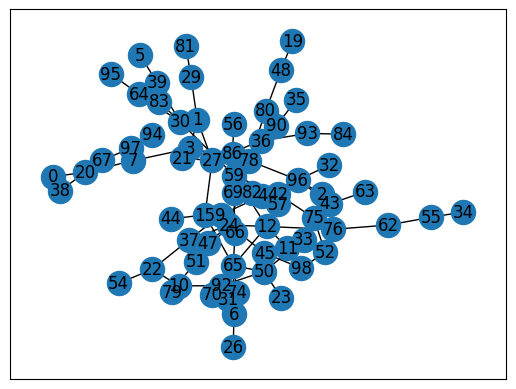

In [7]:
G = G.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

In [9]:
known_nodes = np.array([76, 96, 80, 93, 45, 37, 10, 1, 7, 30]) #picked more or less randomly
unknown_nodes = np.array([n for n in G.nodes if n not in known_nodes])

In [10]:
known_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])
unknown_y = np.array([0 for i in range(len(unknown_nodes))])

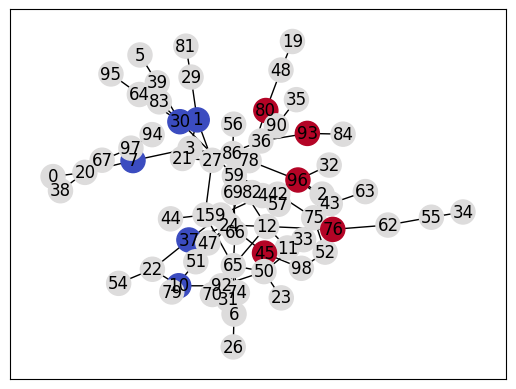

In [13]:
init_labels = dict(zip(np.append(known_nodes, unknown_nodes), np.append(known_y,unknown_y)))
init_colors = [init_labels[i] for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=init_colors, cmap='coolwarm')

In [18]:
A =  nx.adjacency_matrix(G).toarray()
print(A)
print(A.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(73, 73)


In [22]:
A_df = pd.DataFrame(A, index=G.nodes(), columns=G.nodes())
print(A_df)

    0   1   2   3   4   5   6   7   9   10  ...  84  86  90  92  93  94  95  \
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1    0   0   0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3    0   1   0   0   0   0   0   1   0   0  ...   0   0   0   0   0   0   0   
4    0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   0   0   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
94   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
95   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
96   0   0   1   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
97   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1   0   
98   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

    96  97  98  
0    0   0   0  
1    0   0   0  


In [23]:
A_df.loc[29, :][A_df.loc[29, :]  == 1]

1     1
81    1
Name: 29, dtype: int64

In [26]:
# axis=1 means rows
T = np.matrix(A / A.sum(axis=1, keepdims=True))
print(T)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 ...
 [0.  0.  0.2 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
(73, 73)


In [27]:
T_df = pd.DataFrame(T, index=G.nodes(), columns=G.nodes())
T_df.loc[29, :][T_df.loc[29, :]  != 0]

1     0.5
81    0.5
Name: 29, dtype: float64

1. Order your nodes in a way, that the nodes with known labels are first
2. Calculate the adjacency matrix
3. Calculate transition matrix
4. Set probability of going from known node to the same known node as 1, Set all the other probabilities as 0. This way, the probability of going from e.g. node 1 to node 1 is 100%.
5. Update the labels by multiplying the known labels with the resulting transition matrix
6. Repeat until the labels stop changing


In [35]:
def label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.01):
    # Step 1: order nodes
    ordered_nodes = list(known_nodes) + list(unknown_nodes) 
    
    # Step 2: adjacency matrix
    A =  nx.adjacency_matrix(G,nodelist=ordered_nodes).todense()
    A = np.array(A, dtype = np.float64)
    
    # Step 3: transition matrix
    T = A / A.sum(axis=1, keepdims=True)
    
    # Step 4: absorbing nodes
    T[:len(known_nodes), :] = 0
    T[:len(known_nodes), :len(known_nodes)] = np.identity(len(known_nodes)) 
    
    #Step 5 & 6: update labels until convergence
    labels = [Y_init] #stores the label progression for the animation
    Y1 = Y_init 
    for i in tqdm(range(1000)):
        Y0 = Y1
        Y1 = np.dot(T, Y0) #The actual probability update is happening here. 
        diff = np.abs(Y0 - Y1).sum() #calculate the difference between Y(t-1) and Y(t)
        Y1[:len(known_nodes)] = Y_init[:len(known_nodes)] #set the known labels back to their initial values
        labels.append(Y1)
        if i % 10 == 0:
            print('Total difference:', diff)
        if diff < threshold: #stopping criterion
            break

    return labels

In [38]:
Y_init = np.append(known_y, unknown_y) #remember, the known labels (nodes) should always go first
labels = label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.01) #run the algorithm

  8%|▊         | 82/1000 [00:00<00:00, 14871.49it/s]

Total difference: 11.183333333333334
Total difference: 1.1102982053367352
Total difference: 0.4557170878486895
Total difference: 0.2317372035531982
Total difference: 0.12366531606432361
Total difference: 0.06722651043228016
Total difference: 0.03685108906325815
Total difference: 0.02028339262096708
Total difference: 0.011189249412098229


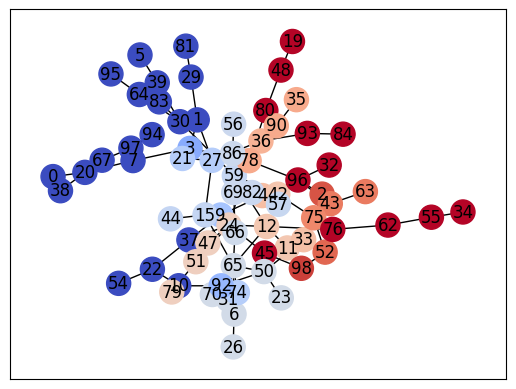

In [39]:
propagated_labels = dict(zip(np.append(known_nodes, unknown_nodes), labels[-1])) #create a dictionary node:label
propagated_colors = [propagated_labels[i] for i in list(G.nodes)] #color intensity for visualisation
nx.draw_networkx(G, pos=pos, node_color=propagated_colors,  cmap='coolwarm')